In [ ]:
# ================================
# 1. Imports & basic configuration
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import scipy

from scipy.ndimage import median_filter
from scipy.signal import find_peaks

plt.style.use("default")  # keep plots clean

# Path to the Dips + Pull-ups CSV file (relative to this notebook)
DATA_PATH = Path("..") / "data" / "Push_Ups.csv"

print("Using data file:", DATA_PATH)

# We only analyse the first 90 seconds of recording
MAX_DURATION_S = 88.0

# Parameters for ENMO smoothing
MEDIAN_FILTER_SIZE = 5          # in samples
MOVING_AVERAGE_WINDOW_S = 0.2   # seconds

# Repetition detection parameters for push-ups
PUSHUPS_MIN_INTERVAL_S = 1.0    # minimal time between two push-ups (s)
PUSHUPS_PERCENTILE = 85         # percentile used for threshold on ENMO_smooth


c:\Users\Hp\miniconda3\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using data file: ..\data\Push_Ups.csv


In [3]:
# =======================================
# 2. Load raw accelerometer data from CSV
# =======================================

def load_pushups_csv(path: str) -> pd.DataFrame:
    """
    Load push-ups accelerometer data exported from OmGui.

    Assumes CSV has no header and columns are:
        0: timestamp (string)
        1: Ax
        2: Ay
        3: Az

    Returns a DataFrame with:
        - timestamp (datetime)
        - t (seconds from start)
        - Ax, Ay, Az (float)
    """
    df = pd.read_csv(path, header=None)
    df.columns = ["timestamp", "Ax", "Ay", "Az"]

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    t0 = df["timestamp"].iloc[0]
    df["t"] = (df["timestamp"] - t0).dt.total_seconds()

    return df


df_raw = load_pushups_csv(DATA_PATH)

print("Number of samples:", len(df_raw))
print("Recording duration (s):", df_raw["t"].iloc[-1])
df_raw.head()

Number of samples: 21000
Recording duration (s): 205.371


,timestamp,Ax,Ay,Az,t
0,2025-11-27 15:00:06.779,0.125000,-0.203125,-1.031250,0.000
1,2025-11-27 15:00:06.789,-0.031250,-0.375000,1.312500,0.010
2,2025-11-27 15:00:06.800,0.031250,-0.390625,1.234375,0.021
3,2025-11-27 15:00:06.809,0.078125,-0.390625,1.093750,0.030
4,2025-11-27 15:00:06.819,0.046875,-0.390625,1.125000,0.040


In [4]:
# ===================================
# 3. Estimate sampling frequency (Hz)
# ===================================

def estimate_sampling_frequency(df: pd.DataFrame) -> float:
    """
    Estimate sampling frequency from timestamp differences.
    """
    dts = df["timestamp"].diff().dt.total_seconds().dropna()
    fs = 1.0 / dts.mean()
    return fs


fs = estimate_sampling_frequency(df_raw)
print(f"Estimated sampling frequency: {fs:.2f} Hz")


Estimated sampling frequency: 102.25 Hz


In [5]:
# ===========================================
# 4. Keep only the first MAX_DURATION_S seconds
# ===========================================

df = df_raw[df_raw["t"] <= MAX_DURATION_S].copy()

print("Number of samples in first", MAX_DURATION_S, "s:", len(df))
print("Time span (s):", df["t"].min(), "to", df["t"].max())
df.head()


Number of samples in first 88.0 s: 8995
Time span (s): 0.0 to 87.992


,timestamp,Ax,Ay,Az,t
0,2025-11-27 15:00:06.779,0.125000,-0.203125,-1.031250,0.000
1,2025-11-27 15:00:06.789,-0.031250,-0.375000,1.312500,0.010
2,2025-11-27 15:00:06.800,0.031250,-0.390625,1.234375,0.021
3,2025-11-27 15:00:06.809,0.078125,-0.390625,1.093750,0.030
4,2025-11-27 15:00:06.819,0.046875,-0.390625,1.125000,0.040


In [6]:
# ==========================================
# 5. Compute ENMO and apply smoothing
# ==========================================

def compute_enmo(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute Euclidean Norm Minus One (ENMO):

        ENMO = max( sqrt(Ax^2 + Ay^2 + Az^2) - 1, 0 )

    Adds a column 'ENMO'.
    """
    ax = df["Ax"].values
    ay = df["Ay"].values
    az = df["Az"].values

    enmo = np.sqrt(ax**2 + ay**2 + az**2) - 1.0
    enmo[enmo < 0] = 0.0
    df["ENMO"] = enmo

    return df


def smooth_enmo(df: pd.DataFrame, fs: float,
                median_size: int = 5,
                ma_window_s: float = 0.2) -> pd.DataFrame:
    """
    Apply median filter + moving average to ENMO.
    Adds a column 'ENMO_smooth'.
    """
    enmo = df["ENMO"].values

    # Median filter to remove spikes
    enmo_med = median_filter(enmo, size=median_size)

    # Moving average over ma_window_s seconds
    kernel_len = max(3, int(ma_window_s * fs))
    enmo_smooth = (
        pd.Series(enmo_med)
        .rolling(window=kernel_len, center=True, min_periods=1)
        .mean()
        .values
    )

    df["ENMO_smooth"] = enmo_smooth
    return df


df = compute_enmo(df)
df = smooth_enmo(
    df,
    fs=fs,
    median_size=MEDIAN_FILTER_SIZE,
    ma_window_s=MOVING_AVERAGE_WINDOW_S,
)

df[["t", "ENMO", "ENMO_smooth"]].head()


,t,ENMO,ENMO_smooth
0,0.000,0.058471,0.171603
1,0.010,0.365378,0.163475
2,0.021,0.295085,0.163013
3,0.030,0.164036,0.166674
4,0.040,0.191810,0.169813


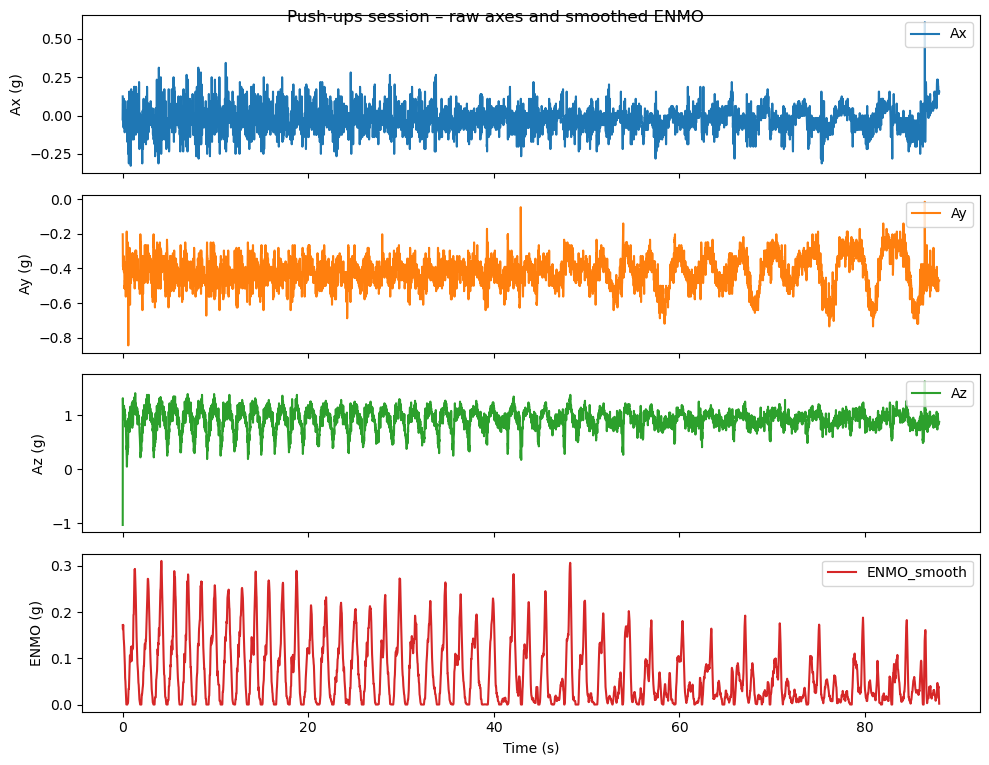

In [7]:
# ===========================================
# 6. Visualise raw axes and smoothed ENMO
# ===========================================

fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axes[0].plot(df["t"], df["Ax"], label="Ax")
axes[0].set_ylabel("Ax (g)")
axes[0].legend(loc="upper right")

axes[1].plot(df["t"], df["Ay"], label="Ay", color="tab:orange")
axes[1].set_ylabel("Ay (g)")
axes[1].legend(loc="upper right")

axes[2].plot(df["t"], df["Az"], label="Az", color="tab:green")
axes[2].set_ylabel("Az (g)")
axes[2].legend(loc="upper right")

axes[3].plot(df["t"], df["ENMO_smooth"], label="ENMO_smooth", color="tab:red")
axes[3].set_ylabel("ENMO (g)")
axes[3].set_xlabel("Time (s)")
axes[3].legend(loc="upper right")

fig.suptitle("Push-ups session – raw axes and smoothed ENMO", y=0.95)
plt.tight_layout()
plt.show()


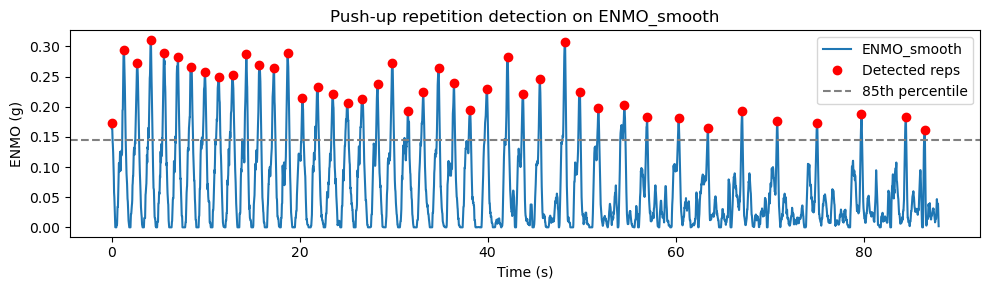

Detected repetitions: 43


,rep_index,t_peak_s,amplitude_g,rep_duration_s,cadence_rpm
0,1,0.050,0.172532,NaN,NaN
1,2,1.318,0.293543,1.268,47.318612
2,3,2.702,0.272165,1.384,43.352601
3,4,4.175,0.310974,1.473,40.733198
4,5,5.556,0.288882,1.381,43.446778


In [8]:
# ============================================
# 7. Repetition detection with peak finding
# ============================================

def detect_pushup_repetitions(df: pd.DataFrame,
                              fs: float,
                              min_interval_s: float = 1.0,
                              percentile: float = 85,
                              plot: bool = True) -> pd.DataFrame:
    """
    Detect push-up repetitions on ENMO_smooth using peak detection.
    
    Returns a DataFrame with one row per repetition:
        - rep_index
        - t_peak_s
        - amplitude_g
        - rep_duration_s (time from previous rep)
        - cadence_rpm   (local cadence between reps)
    """
    t = df["t"].values
    signal = df["ENMO_smooth"].values

    # Adaptive amplitude threshold based on given percentile
    thr = np.percentile(signal, percentile)

    # Minimum distance between two reps (in samples)
    min_distance = int(min_interval_s * fs)

    # Peak detection
    peaks, properties = find_peaks(
        signal,
        height=thr,
        distance=min_distance
    )

    if len(peaks) == 0:
        print("No peaks detected – check parameters.")
        return pd.DataFrame()

    t_peaks = t[peaks]
    amp_peaks = properties["peak_heights"]

    # Rep durations and cadence (from interval between peaks)
    rep_indices = np.arange(1, len(peaks) + 1)

    rep_durations = np.full_like(t_peaks, np.nan, dtype=float)
    cadence_rpm = np.full_like(t_peaks, np.nan, dtype=float)

    if len(t_peaks) > 1:
        intervals = np.diff(t_peaks)              # seconds between reps
        rep_durations[1:] = intervals
        cadence_rpm[1:] = 60.0 / intervals       # reps per minute

    reps_df = pd.DataFrame(
        {
            "rep_index": rep_indices,
            "t_peak_s": t_peaks,
            "amplitude_g": amp_peaks,
            "rep_duration_s": rep_durations,
            "cadence_rpm": cadence_rpm,
        }
    )

    # Optional visualization
    if plot:
        plt.figure(figsize=(10, 3))
        plt.plot(t, signal, label="ENMO_smooth")
        plt.plot(t_peaks, amp_peaks, "ro", label="Detected reps")
        plt.axhline(thr, color="grey", linestyle="--",
                    label=f"{percentile}th percentile")
        plt.xlabel("Time (s)")
        plt.ylabel("ENMO (g)")
        plt.title("Push-up repetition detection on ENMO_smooth")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

    return reps_df


reps = detect_pushup_repetitions(
    df,
    fs=fs,
    min_interval_s=PUSHUPS_MIN_INTERVAL_S,
    percentile=PUSHUPS_PERCENTILE,
    plot=True,
)

print(f"Detected repetitions: {len(reps)}")
reps.head()


In [9]:
# ============================================
# 8. Global summary of the push-ups set
# ============================================

total_reps = len(reps)
effective_duration_s = df["t"].max() - df["t"].min()

# Remove NaNs for statistics (first rep has NaN for duration & cadence)
rep_durations = reps["rep_duration_s"].dropna()
cadences = reps["cadence_rpm"].dropna()

print(f"Total repetitions: {total_reps}")
print(f"Analysed duration: {effective_duration_s:.1f} s")
if len(rep_durations) > 0:
    print(f"Mean rep duration: {rep_durations.mean():.2f} s")
    print(f"Std rep duration:  {rep_durations.std():.2f} s")
if len(cadences) > 0:
    print(f"Mean cadence:      {cadences.mean():.1f} reps/min")
    print(f"Std cadence:       {cadences.std():.1f} reps/min")

reps.describe()


Total repetitions: 43
Analysed duration: 88.0 s
Mean rep duration: 2.06 s
Std rep duration:  0.94 s
Mean cadence:      33.3 reps/min
Std cadence:       9.7 reps/min


,rep_index,t_peak_s,amplitude_g,rep_duration_s,cadence_rpm
count,43.000000,43.000000,43.000000,42.000000,42.000000
mean,22.000000,34.867837,0.232077,2.058500,33.265060
std,12.556539,24.308918,0.042872,0.938687,9.678387
min,1.000000,0.050000,0.161221,1.268000,12.687672
25%,11.500000,15.028000,0.193726,1.488250,27.720482
50%,22.000000,31.514000,0.229764,1.629500,36.821114
75%,32.500000,50.793000,0.267440,2.168750,40.316381
max,43.000000,86.507000,0.310974,4.729000,47.318612


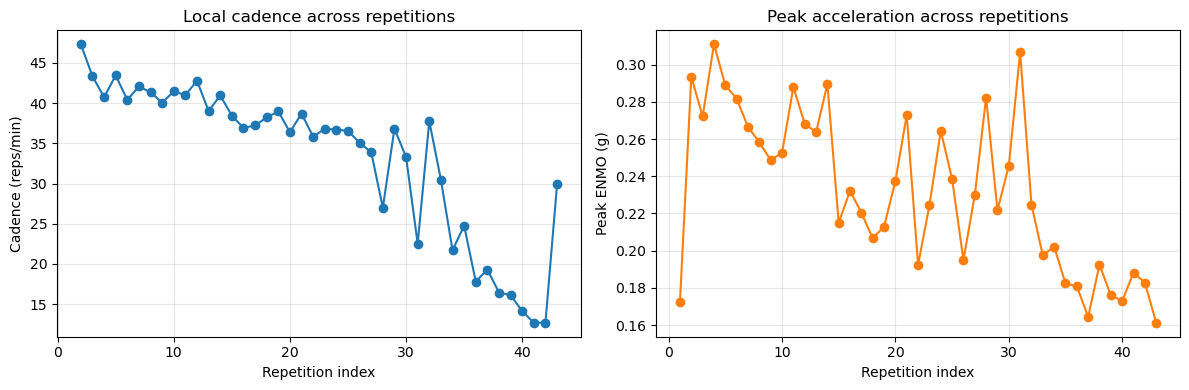

In [11]:
# ==========================================================
# 9. Visualising fatigue: cadence and amplitude vs rep index
# ==========================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Cadence vs rep index
axes[0].plot(reps["rep_index"], reps["cadence_rpm"],
             marker="o", linestyle="-")
axes[0].set_xlabel("Repetition index")
axes[0].set_ylabel("Cadence (reps/min)")
axes[0].set_title("Local cadence across repetitions")
axes[0].grid(True, alpha=0.3)

# Amplitude vs rep index
axes[1].plot(reps["rep_index"], reps["amplitude_g"],
             marker="o", linestyle="-", color="tab:orange")
axes[1].set_xlabel("Repetition index")
axes[1].set_ylabel("Peak ENMO (g)")
axes[1].set_title("Peak acceleration across repetitions")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
# =====================================================
# 10. Early vs mid vs late repetitions: simple analysis
# =====================================================

def add_phase_column(reps_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a 'phase' column: 'early', 'middle', 'late'
    based on rep_index tertiles.
    """
    n = len(reps_df)
    if n < 3:
        reps_df["phase"] = "all"
        return reps_df

    # cut into three roughly equal parts
    tertiles = np.linspace(1, n+1, 4, dtype=int)  # [1, ..., n+1]
    bounds = list(zip(tertiles[:-1], tertiles[1:]))

    phase_labels = ["early", "middle", "late"]
    phase = []

    for idx in reps_df["rep_index"]:
        if idx >= bounds[0][0] and idx < bounds[0][1]:
            phase.append("early")
        elif idx >= bounds[1][0] and idx < bounds[1][1]:
            phase.append("middle")
        else:
            phase.append("late")

    reps_df = reps_df.copy()
    reps_df["phase"] = phase
    return reps_df


reps_phase = add_phase_column(reps)

# Summary statistics by phase
phase_summary = (
    reps_phase
    .groupby("phase")
    .agg(
        n_reps=("rep_index", "count"),
        mean_rep_duration=("rep_duration_s", "mean"),
        mean_cadence=("cadence_rpm", "mean"),
        mean_amplitude=("amplitude_g", "mean"),
    )
    .round(2)
    .reset_index()
)

phase_summary

,phase,n_reps,mean_rep_duration,mean_cadence,mean_amplitude
0,early,14,1.44,41.84,0.27
1,late,15,2.96,23.10,0.20
2,middle,14,1.67,36.19,0.23
